In [1]:
import torch

In [2]:
import math
import numpy as npy
import matplotlib.pyplot as plt

In [3]:
def f (x):
    return 3*x**2 - 4*x + 5

In [4]:
6*(3) - 4

14

In [5]:
x = npy.arange (-5, 5 + 0.25, 0.25)
y = f (x)

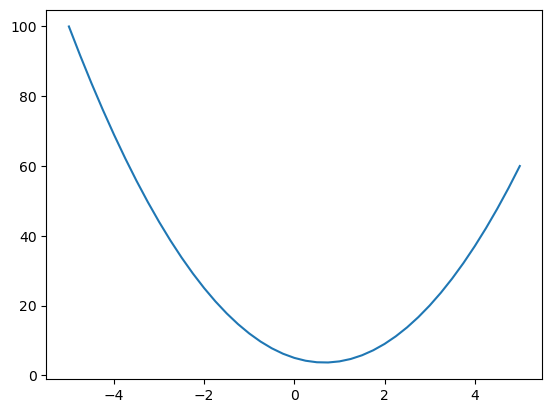

In [6]:
plt.plot (x, y)

In [7]:
h = 0.001
x = 2/3
(f (x + h) - f (x)) / h

0.0029999999995311555

In [8]:
h = 0.00000000001

In [9]:
a = 10.0
b = -2.0
c = 3

In [10]:
d1 = a * b + c
a += h
d2 = a * b + c


# diff wrt a
# a*b+c -> b
(d2 - d1) / h

-1.9998225297968022

In [11]:
d1 = a * b + c
b += h
d2 = a * b + c


# diff wrt b
# a*b+c -> a
(d2 - d1) / h

10.00017846308765

In [12]:
d1 = a * b + c
c += h
d2 = a * b + c


# diff wrt c
# a*b+c -> 1
(d2 - d1) / h

1.000088900582341

In [190]:
import math

class Value:
    def __init__ (self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set (_children)
        self._op = _op
        self.label = label
        
    def __repr__ (self):
        return f'{self.data}'
    
    def __add__ (self, other):
        other = other if isinstance (other, Value) else Value (other)
        out = Value (self.data + other.data, _children=(self, other), _op='+')
        
        def _backward ():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__ (self, other):
        other = other if isinstance (other, Value) else Value (other)
        out = Value (self.data * other.data, (self, other), '*')

        def _backward ():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__ (self, other):
        assert isinstance (other, (int, float)), "only supporting int/float powers for now"
        out = Value (self.data ** other, (self,), f'**{other}')

        def _backward ():
            self.grad += (other * self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__ (self, other):
        out = self.__mul__ (other)
        return out
    
    def __truediv__ (self, other):
        out = self * (other ** -1)
        return out

    def __neg__ (self):
        return self.__mul__ (-1)
    
    def __sub__ (self, other):
        out = self.__add__ (-other)
        return out
    
    def __radd__ (self, other):
        return self + other
    
    def tanh (self):
        x = self.data
        t = (math.exp (x) - math.exp (-x)) / (math.exp (x) + math.exp (-x))
        out = Value (t, label='tanh', _children=(self, ))
        
        def _backward ():
            self.grad += (1 - (t ** 2)) * out.grad
        out._backward = _backward
        
        return out
    
    def exp (self):
        x = self.data
        out = Value (math.exp (x), (self, ), 'exp')
        
        def _backward ():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def item (self):
        return self.data
    
    def relu (self):
        x = self.data
        out = Value ((x + math.abs (x)) / 2, (self, ), 'relu')

        def _backward ():
            self.grad += (1 if x > 0 else 0) * out.grad
        out._backward = _backward
        
        return out
    
    def sigmoid (self):
        x = self.data
        out = Value (, (self, ), 'sigmoid')

        def _backward ():
            self.grad += (out.data * (1 - out.data)) * out.grad
        out._backward = _backward
    
        return out
    
    def backward (self):
        topo = list ()
        seen = set ()
        
        def build_topo (root):
            if root not in seen:
                seen.add (root)
                for node in root._prev:
                    build_topo (node)
                topo.append (root)
        
        build_topo (self)
        
        self.grad = 1.0
        for node in reversed (topo):
            node._backward ()

In [199]:
1 / (1 + math.exp (-10.0))

0.9999546021312976

In [201]:
1 * ((1 + math.exp (-10.0)) ** (1 / 2))

1.000022699707243

In [4]:
a = Value (3.0, label='a')
b = Value (2.0, label='b')
c = a + b; c.label = 'c'
c.grad = 1.0

In [5]:
c._backward ()

In [6]:
a = Value (3.0, label='a')
b = Value (2.0, label='b')
c = a * b
c.label = 'c'; c

6.0

In [7]:
c._prev, c._op

({2.0, 3.0}, '*')

In [8]:
d = Value (1.0, label='d')
e = c + d
e.label = 'e'
f = Value (-2.0, label='f')
L = e - f; L.label = 'L'

In [9]:
L._prev, L._op

({2.0, 7.0}, '+')

In [19]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data=%.4f | grad=%.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

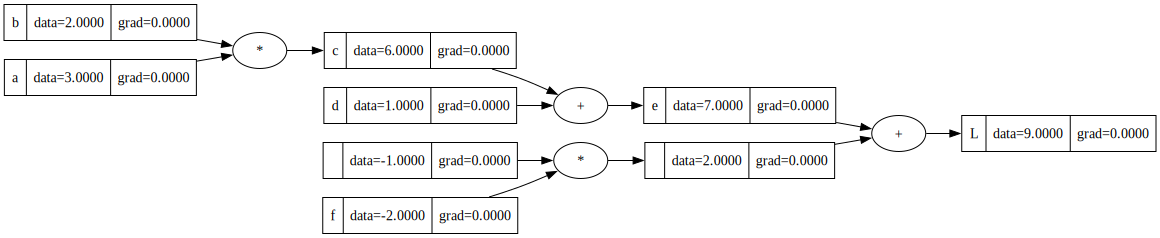

In [10]:
draw_dot (L)

# loss.backward ()

In [59]:
L.grad = 1

In [60]:
# L = e - f
# dL / df => -1.0

In [61]:
f.grad = -1

In [62]:
# L = e - f
# dL / de => 1.0

In [63]:
e.grad = 1

In [64]:
# e = c + d

# de / dc => 1.0
# de / dd => 1.0

# dL / dc => (dL / de) * (de / dc) => 1.0 * 1.0
# dL / dc => 1.0

# dL / dd => (dL / de) * (de / dd) => 1.0 * 1.0
# dL / dd => 1.0

In [65]:
c.grad = 1.0
d.grad = 1.0

In [66]:
# c = a * b

# dc / da => 2.0
# dL / da => (dL / dc) * (dc / da)
# dL / da => 1.0 * 2 => 2.0

# dc / db => 3.0
# dL / db => (dL / dc) * (dc / db)
# dL / db => 1.0 * 3 => 3.0

In [67]:
a.grad = 2.0
b.grad = 3.0

In [68]:
h = 0.00000001

x = -1.0
y = 3.0
z = x * y

In [69]:
d1 = x * y
y += h
d2 = x * y
(d2 - d1) / h

-0.999999993922529

In [465]:
def derivative ():
    
    h = 0.000001
    
    # d1
    a = 3
    b = 2
    c = a * b
    
    d = 1
    e = c + d
    
    f = -2
    L1 = e - f
    
    # d2
    a = 3
    b = 2
    c = a * b
    
    d = 1
    e = c + (d + h)
    
    f = -2
    L2 = e - f
    
    return (L2 - L1) / h

derivative ()

1.0000000010279564

# optimizer.step ()

In [71]:
lr = 0.01

a.data += -lr * a.grad
b.data += -lr * b.grad
c.data += -lr * c.grad
f.data += -lr * f.grad

In [72]:
c = a * b; c.label = 'c'
e = c + d; e.label = 'e'
L = e - f; L.label = 'L'

In [73]:
L.data

9.1406

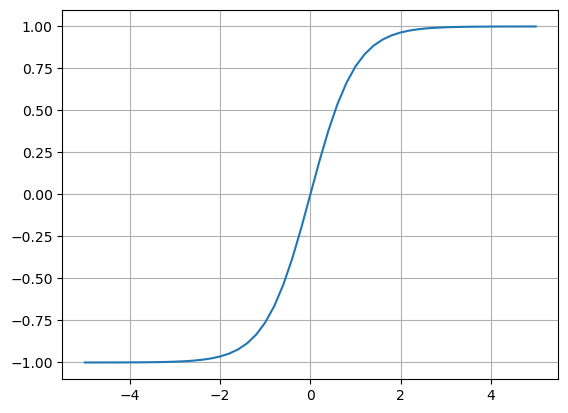

In [74]:
X = npy.arange (-5, 5 + 0.2, 0.2)
plt.plot (X, npy.tanh (X))
plt.grid ()

In [195]:
# inputs
x1 = Value (-2.0, label='x1')
x2 = Value (0.0, label='x2')

# weights 
w1 = Value (-3.0, label='w1')
w2 = Value (1.0, label='w2')

# bias
B = Value (-2.0, label='B')

In [196]:
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
wixi = w1x1 + w2x2; wixi.label = 'wixi'
n = wixi + B; n.label = 'n'
out = n.tanh (); out.label = 'out'

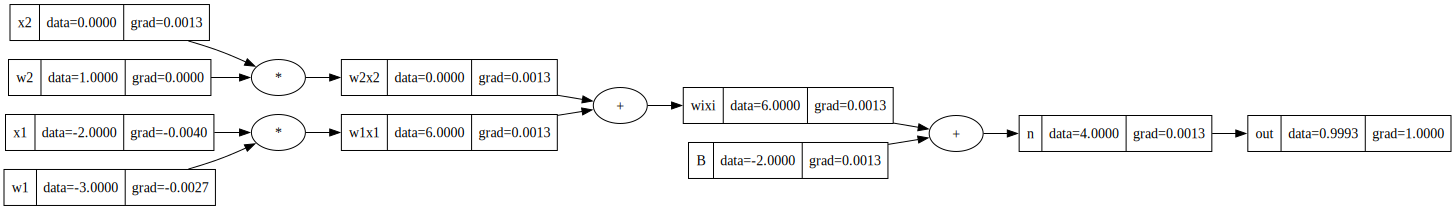

In [199]:
draw_dot (out)

In [198]:
out.backward ()

In [224]:
import torch

# inputs
x1 = torch.Tensor ([-2.0]); x1.requires_grad = True
x2 = torch.Tensor ([0.0]); x2.requires_grad = True

# weights 
w1 = torch.Tensor ([-3.0]); w1.requires_grad = True
w2 = torch.Tensor ([1.0]); w2.requires_grad = True

# bias
B = torch.Tensor ([-2.0]); B.requires_grad = True

In [225]:
act = ((w1 * x1) + (w2 * x2)) + B 
act = torch.tanh (act)

In [226]:
act

tensor([0.9993], grad_fn=<TanhBackward0>)

In [228]:
act.backward ()

In [231]:
x1.grad.item ()

-0.0040225982666015625

In [30]:
import random

In [31]:
class Neuron:
    def __init__ (self, in_channels):
        self.w = [Value (random.uniform (-1, 1)) for i in range (in_channels)]
        self.b = Value (random.uniform (-1, 1))
    
    def __call__ (self, inputs):
        out = sum ([w * x for w, x in zip (self.w, inputs)]) + self.b
        act = out.tanh ()
        return act
    
    def parameters (self):
        return self.w + [self.b]

In [32]:
class Linear:
    def __init__ (self, in_channels, out_channels):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.neurons = [Neuron (in_channels) for _ in range (out_channels)]
        
    def __call__ (self, x):
        assert len (x) == self.in_channels, f'dimention mismatch, expected: {self.in_channels}, got: {len (x)}'
        outs = [neuron (x) for neuron in self.neurons]
        return outs
    
    def __repr__ (self):
        return f'Linear (in_channels={self.in_channels}, out_channels={self.out_channels})'
    
    def parameters (self):
        return [p for neuron in self.neurons for p in neuron.parameters ()]

In [33]:
class NeuralNet:
    def __init__ (self, n_layer=(100,)):
        self.n_layer = n_layer
        self.layers = [Linear (self.n_layer[i], self.n_layer[i + 1]) for i in range (len (self.n_layer) - 1)]
        
    def __repr__ (self):
        return f'NeuralNet {self.n_layer}'
        
    def __call__ (self, x):
        for layer in self.layers:
            x = layer (x)
        return x
    
    def parameters (self):
        return [p for layer in self.layers for p in layer.parameters ()]

In [34]:
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
yhat = [0, 1, 1, 0]

epochs = 1000
lr = 0.01

model = NeuralNet (n_layer=(2, 6, 6, 1))

In [424]:
for epoch in range (epochs):
    for xs, ytrue in zip (X, yhat):
        for p in model.parameters ():
            p.grad = 0

        ypred = model (xs)
        loss = (Value (ytrue) - ypred[0]) * (Value (ytrue) - ypred[0])
        loss.backward ()

        for p in model.parameters ():
            p.data += -lr * p.grad

In [427]:
for xs in X:
    print (xs, 1 if model (xs)[0].item () > 0.5 else 0)

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] 0


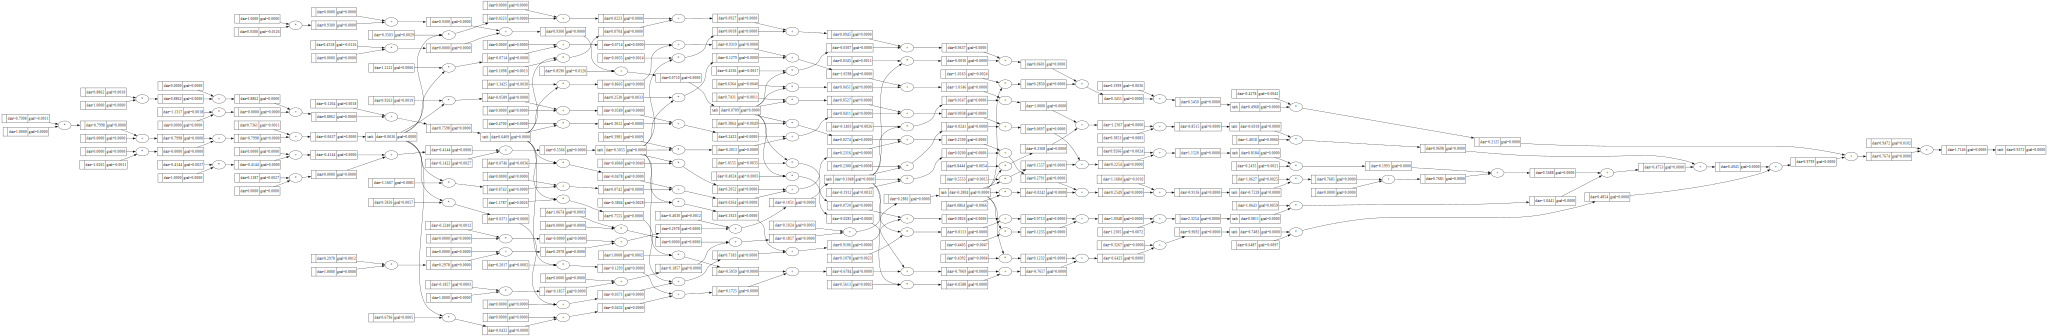

In [429]:
draw_dot (model ([1, 0])[0])

In [166]:
x1 = Value (2.0, label='x1')
x2 = Value (3.0, label='x2')

In [167]:
w1 = Value (2.0, label='w1')
w2 = Value (2.0, label='w2')
w3 = Value (1.0, label='w3')
w4 = Value (2.0, label='w4')

In [168]:
x1w1x2w3 = (x1 * w1) + (x2 * w3); x1w1x2w3.label = 'x1w1x2w3'
x1w2x2w4 = (x1 * w2) + (x2 * w4); x1w2x2w4.label = 'x1w2x2w4'

In [169]:
w5 = Value (1.0, label='w5')
w6 = Value (1.0, label='w6')

In [170]:
out = (x1w1x2w3 * w5) + (x1w2x2w4 * w6); out.label = 'out'

In [171]:
act = out.sigmoid (); act.label = 'act'

TypeError: Value.__init__() got multiple values for argument '_children'

In [164]:
ytrue = Value (10.0, label='ytrue')

In [155]:
loss = (ytrue - ypred) ** 2

In [156]:
draw_dot (act)

AttributeError: 'str' object has no attribute '_prev'

In [104]:
loss.backward ()

In [174]:
lr = 0.01

w1.data = -lr * w1.grad
w2.data = -lr * w2.grad
w3.data = -lr * w3.grad
w4.data = -lr * w4.grad
w5.data = -lr * w5.grad
w6.data = -lr * w6.grad

In [175]:
x1 = Value (2.0, label='x1')
x2 = Value (3.0, label='x2')

In [176]:
x1w1x2w3 = (x1 * w1) + (x2 * w3); x1w1x2w3.label = 'x1w1x2w3'
x1w2x2w4 = (x1 * w2) + (x2 * w4); x1w2x2w4.label = 'x1w2x2w4'

In [177]:
out = (x1w1x2w3 * w5) + (x1w2x2w4 * w6); out.label = 'out'

In [178]:
ytrue = Value (10.0, label='ytrue')

In [179]:
act = out.sigmoid (); act.label = 'act'

TypeError: must be real number, not Value

In [121]:
loss = (ytrue - ypred) ** 2

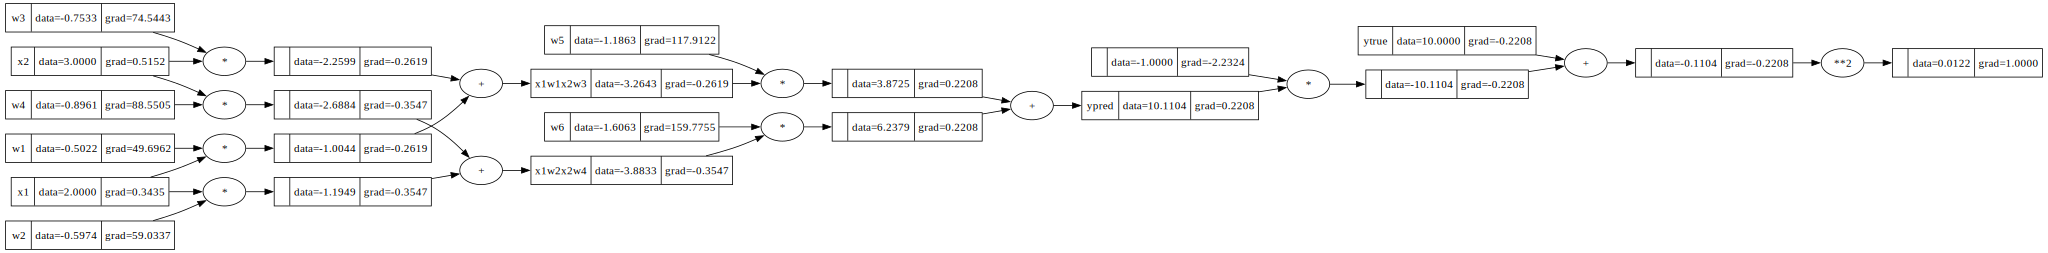

In [125]:
draw_dot (loss)

In [124]:
loss.backward ()